# Install Libraries

In [ ]:
# !pip install clearml
# !pip install xgboost
# !pip install pandas
# !pip install scikit-learn
# !pip install matplotlib
# !pip install torch
# !pip install tensorboard 

# Imports

In [1]:
import clearml
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import psutil
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
d = psutil.disk_usage('/')
print(f"total: {d.total} bytes")
print(f"used: {d.used} bytes")
print(f"free: {d.free} bytes")

total: 52741595136 bytes
used: 18829897728 bytes
free: 31694131200 bytes


# Connect to Browser

In [3]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=CEXP8BVY587LDKN4L2N6
%env CLEARML_API_SECRET_KEY=QzzgTEb2qDtZTg8JwPPXVSe4lMiMQiGJjFTwanDuIqimPJjwhR

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=CEXP8BVY587LDKN4L2N6
env: CLEARML_API_SECRET_KEY=QzzgTEb2qDtZTg8JwPPXVSe4lMiMQiGJjFTwanDuIqimPJjwhR


In [4]:
clearml.browser_login()

In [6]:
from clearml import Task

# Machine Learning

In [29]:
# Task.get_task('51978157a6e343eea5b3d256cc844d00').delete()

## Create ClearML Task and Data

In [8]:
task_xgb = Task.init(project_name="lab_03_devops", 
                 task_name="xgb_cricket_prediction", 
                 output_uri=True)
all_projects = Task.get_projects()
lab_03_devops_project = all_projects[-1]
print(lab_03_devops_project)

ClearML Task: created new task id=0e79f82d492b4019a0230d95f40f2cbc
2023-05-24 20:14:21,229 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/ed74f016950a48ea96a7b667648d4a7c/experiments/0e79f82d492b4019a0230d95f40f2cbc/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
<projects.Project: {
    "id": "ed74f016950a48ea96a7b667648d4a7c",
    "name": "lab_03_devops",
    "basename": "lab_03_devops",
    "description": "# Cricket_Match_Outcome_Predictioon\n## Steps",
    "user": "99c0427d647d48d9a72ce56bb0e511b5",
    "company": "c4a3a246af4a4e28ba4683ae2352b187",
    "created": "2023-05-24 15:20:47.122000+00:00",
    "tags": [],
    "system_tags": [],
    "last_update": "2023-05-24 20:14:20.274000+00:00"
}>


In [9]:
ipl_df = pd.read_csv('data/ipl_data.csv', low_memory=True)
ipl_df.drop(['id'], axis=1, inplace=True)
print(ipl_df.shape, ipl_df.columns)

(958, 10) Index(['home', 'away', 'date', 'match_type', 'venue', 'time_of_match', 'toss',
       'winner', 'man_of_match', 'outcome'],
      dtype='object')


In [10]:
ipl_df.head(5)

,home,away,date,match_type,venue,time_of_match,toss,winner,man_of_match,outcome
0,Royal Challengers Bangalore,Kolkata Knight Riders,"18th April, 2008",league,"M Chinnaswamy Stadium, Bengaluru, Bangalore",Day/Night Match,Royal Challengers Bangalore,Kolkata Knight Riders,Brendon McCullum,0
1,Kings XI Punjab,Chennai Super Kings,"19th April, 2008",league,"Punjab Cricket Association IS Bindra Stadium, ...",Day/Night Match,Chennai Super Kings,Chennai Super Kings,Michael Hussey,0
2,Delhi Daredevils,Rajasthan Royals,"19th April, 2008",league,"Arun Jaitley Stadium, Delhi",Day/Night Match,Rajasthan Royals,Delhi Daredevils,Farveez Maharoof,1
3,Kolkata Knight Riders,Deccan Chargers,"20th April, 2008",league,"Eden Gardens, Kolkata",Day/Night Match,Deccan Chargers,Kolkata Knight Riders,David Hussey,1
4,Mumbai Indians,Royal Challengers Bangalore,"20th April, 2008",league,"Wankhede Stadium, Mumbai",Day/Night Match,Mumbai Indians,Royal Challengers Bangalore,Mark Boucher,0


In [11]:
ipl_df.dtypes

home             object
away             object
date             object
match_type       object
venue            object
time_of_match    object
toss             object
winner           object
man_of_match     object
outcome           int64
dtype: object

In [12]:
cols_to_convert_to_category = ipl_df.columns[:-1]
ipl_df[cols_to_convert_to_category] = ipl_df[cols_to_convert_to_category].astype('category')

In [13]:
ipl_df.dtypes

home             category
away             category
date             category
match_type       category
venue            category
time_of_match    category
toss             category
winner           category
man_of_match     category
outcome             int64
dtype: object

## Model Train, Test and Basic Logging

In [14]:
X = ipl_df.drop(['outcome'], axis=1)
y = ipl_df['outcome']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
data_train_matrix = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
data_val_matrix = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
data_test_matrix = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

In [15]:
params = {
    'max_depth': 2,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
    'nthread': 4,
    'colsample_bytree': 0.5,
    'eval_metric': 'logloss',
    'subsample': 0.5,
    'gamma':0.1
}
task_xgb.connect(params)

{'max_depth': 2,
 'learning_rate': 0.1,
 'objective': 'binary:logistic',
 'nthread': 4,
 'colsample_bytree': 0.5,
 'eval_metric': 'logloss',
 'subsample': 0.5,
 'gamma': 0.1}

In [16]:
xgb_model = xgb.train(
        params,
        data_train_matrix,
        num_boost_round=150,
        evals=[(data_train_matrix, "train"), (data_val_matrix, "eval")],
        verbose_eval=0,
)
xgb_model.save_model("best_model")

accuracy = 0.883


2023-05-24 20:14:40,460 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/lab_03_devops/xgb_cricket_prediction.0e79f82d492b4019a0230d95f40f2cbc/models/best_model


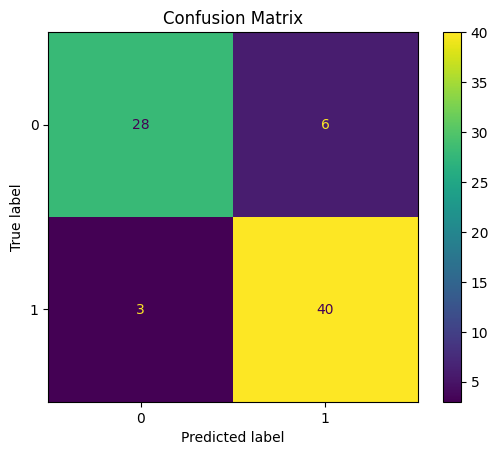

In [17]:
y_pred_probas = xgb_model.predict(data_test_matrix)
y_pred = [1 if p > 0.5 else 0 for p in y_pred_probas]
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy = {round(accuracy, 3)}")
cm = confusion_matrix(y_test, y_pred)
plt.title("Confusion Matrix")
ConfusionMatrixDisplay(cm).plot(ax=plt.gca())

In [18]:
task_xgb.close()

# Deep Learning with Tensorboard and Pytorch

## Create ML Task and Data

In [19]:
task_nn = Task.init(project_name="lab_03_devops", 
                 task_name="tensorboard_pytorch_cricket_prediction", 
                 output_uri=True)
all_projects = Task.get_projects()
lab_03_devops_project = all_projects[-1]
print(lab_03_devops_project)

ClearML Task: created new task id=a0c88d023b43430cb4525baf80ceb4ce
ClearML results page: https://app.clear.ml/projects/ed74f016950a48ea96a7b667648d4a7c/experiments/a0c88d023b43430cb4525baf80ceb4ce/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
<projects.Project: {
    "id": "ed74f016950a48ea96a7b667648d4a7c",
    "name": "lab_03_devops",
    "basename": "lab_03_devops",
    "description": "# Cricket_Match_Outcome_Predictioon\n## Steps",
    "user": "99c0427d647d48d9a72ce56bb0e511b5",
    "company": "c4a3a246af4a4e28ba4683ae2352b187",
    "created": "2023-05-24 15:20:47.122000+00:00",
    "tags": [],
    "system_tags": [],
    "last_update": "2023-05-24 20:15:07.468000+00:00"
}>


In [20]:
ipl_df = pd.read_csv('data/ipl_data.csv', low_memory=True)
ipl_df.drop(['id'], axis=1, inplace=True)
print(ipl_df.shape, ipl_df.columns)
ipl_df.dtypes

(958, 10) Index(['home', 'away', 'date', 'match_type', 'venue', 'time_of_match', 'toss',
       'winner', 'man_of_match', 'outcome'],
      dtype='object')


home             object
away             object
date             object
match_type       object
venue            object
time_of_match    object
toss             object
winner           object
man_of_match     object
outcome           int64
dtype: object

## Model Train, Test and TensorBoard Logging

In [21]:
# Define the custom dataset class
class IPLDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.FloatTensor(labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.data)
    
# Get data in desired format and split
X, y = ipl_df.iloc[:, :-1], ipl_df.iloc[:, -1]
print(X.shape)
X = pd.get_dummies(X)
print(X.shape)
X, y = X.to_numpy(), y.to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# Instantiate the datasets and dataloaders
train_dataset = IPLDataset(X_train, y_train)
val_dataset = IPLDataset(X_val, y_val)
test_dataset = IPLDataset(X_test, y_test)

(958, 9)
(958, 1077)


In [22]:
# Define the neural network architecture
class IPL_match_outcome_BNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.5):
        super(IPL_match_outcome_BNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 8)
        self.fc4 = nn.Linear(hidden_size // 8, 1)
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))
        return x

In [23]:
writer = SummaryWriter()

In [24]:
# Hyperparameters
input_size = X.shape[1] 
hidden_size = X.shape[1] // 2
learning_rate = 0.001
batch_size = 32
num_epochs = 50

# Data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Model
model = IPL_match_outcome_BNN(input_size, hidden_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)

IPL_match_outcome_BNN(
  (fc1): Linear(in_features=1077, out_features=538, bias=True)
  (fc2): Linear(in_features=538, out_features=269, bias=True)
  (fc3): Linear(in_features=269, out_features=67, bias=True)
  (fc4): Linear(in_features=67, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)


In [25]:
# Train
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Convert predictions and labels to integers for accuracy calculation
        train_predictions = outputs.round().squeeze().detach().cpu().numpy()
        train_labels = labels.detach().cpu().numpy()
        train_correct += (train_predictions == train_labels).sum()
        train_total += len(train_labels)

    # Compute the training accuracy
    train_accuracy = train_correct / train_total

    # Perform validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    for inputs, labels in val_dataloader:
        val_outputs = model(inputs)
        val_loss += criterion(val_outputs.squeeze(), labels).item()

        # Convert predictions and labels to integers for accuracy calculation
        val_predictions = val_outputs.round().squeeze().detach().cpu().numpy()
        val_labels = labels.detach().cpu().numpy()
        val_correct += (val_predictions == val_labels).sum()
        val_total += len(val_labels)

    # Compute the validation accuracy
    val_accuracy = val_correct / val_total
    if epoch % 12 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], \
        Train Loss: {train_loss:.4f}, \
        Train Accuracy: {train_accuracy:.4f}, \
        Validation Loss: {val_loss:.4f}, \
        Validation Accuracy: {val_accuracy:.4f}")


Epoch [1/50],         Train Loss: 15.3040,         Train Accuracy: 0.4804,         Validation Loss: 4.1527,         Validation Accuracy: 0.5052
Epoch [13/50],         Train Loss: 0.0111,         Train Accuracy: 1.0000,         Validation Loss: 3.7331,         Validation Accuracy: 0.8125
Epoch [25/50],         Train Loss: 0.0016,         Train Accuracy: 1.0000,         Validation Loss: 4.3413,         Validation Accuracy: 0.7917
Epoch [37/50],         Train Loss: 0.0013,         Train Accuracy: 1.0000,         Validation Loss: 5.5273,         Validation Accuracy: 0.7812
Epoch [49/50],         Train Loss: 0.0012,         Train Accuracy: 1.0000,         Validation Loss: 6.2095,         Validation Accuracy: 0.7812


Test Accuracy: 0.8442


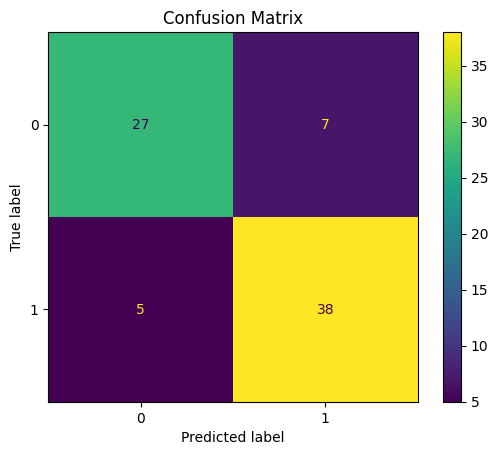

In [26]:
model.eval()
test_predictions = []
test_labels = []
for inputs, labels in test_dataloader:
    outputs = model(inputs)
    predictions = outputs.round().squeeze().detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    test_predictions.extend(predictions)
    test_labels.extend(labels)

test_predictions = np.array(test_predictions)
test_labels = np.array(test_labels)
test_accuracy = (test_predictions == test_labels).mean()
print(f"Test Accuracy: {test_accuracy:.4f}")
cm = confusion_matrix(test_labels, test_predictions)
plt.title("Confusion Matrix")
ConfusionMatrixDisplay(cm).plot(ax=plt.gca())

In [27]:
writer.close()

In [28]:
task_nn.close()